In [1]:
!pip install numpy pandas matplotlib seaborn scikit-learn

import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns

from sklearn.pipeline import Pipeline
from sklearn.compose import ColumnTransformer
from sklearn.preprocessing import StandardScaler, OneHotEncoder
from sklearn.ensemble import RandomForestClassifier
from sklearn.linear_model import LogisticRegression
from sklearn.model_selection import train_test_split, StratifiedKFold, GridSearchCV
from sklearn.metrics import classification_report, confusion_matrix, ConfusionMatrixDisplay

In [9]:
# Load the dataset from a local CSV file
df = pd.read_csv('weatherAUS.csv')

# Show the first few rows
df.head()

,Date,Location,MinTemp,MaxTemp,Rainfall,Evaporation,Sunshine,WindGustDir,WindGustSpeed,WindDir9am,...,Humidity9am,Humidity3pm,Pressure9am,Pressure3pm,Cloud9am,Cloud3pm,Temp9am,Temp3pm,RainToday,RainTomorrow
0,2008-12-01,Albury,13.4,22.9,0.6,NaN,NaN,W,44.0,W,...,71.0,22.0,1007.7,1007.1,8.0,NaN,16.9,21.8,No,No
1,2008-12-02,Albury,7.4,25.1,0.0,NaN,NaN,WNW,44.0,NNW,...,44.0,25.0,1010.6,1007.8,NaN,NaN,17.2,24.3,No,No
2,2008-12-03,Albury,12.9,25.7,0.0,NaN,NaN,WSW,46.0,W,...,38.0,30.0,1007.6,1008.7,NaN,2.0,21.0,23.2,No,No
3,2008-12-04,Albury,9.2,28.0,0.0,NaN,NaN,NE,24.0,SE,...,45.0,16.0,1017.6,1012.8,NaN,NaN,18.1,26.5,No,No
4,2008-12-05,Albury,17.5,32.3,1.0,NaN,NaN,W,41.0,ENE,...,82.0,33.0,1010.8,1006.0,7.0,8.0,17.8,29.7,No,No


In [11]:
# Drop all rows that contain any missing values (NaN)
# This is a quick fix to clean the dataset; more advanced workflows might impute instead
df.dropna(inplace=True)

# Confirm the shape of the cleaned dataset
print(f"Remaining rows after dropping missing data: {df.shape[0]}")

Remaining rows after dropping missing data: 56420


In [13]:
# Rename 'RainTomorrow' to 'RainLabel' (this is our classification target)
# Rename 'RainToday' to 'RainTodayFlag' (a binary input feature)
df.rename(columns={
    "RainTomorrow": "RainLabel",
    "RainToday": "RainTodayFlag"
}, inplace=True)

# Preview the updated DataFrame column names
df.columns

Index(['Date', 'Location', 'MinTemp', 'MaxTemp', 'Rainfall', 'Evaporation',
       'Sunshine', 'WindGustDir', 'WindGustSpeed', 'WindDir9am', 'WindDir3pm',
       'WindSpeed9am', 'WindSpeed3pm', 'Humidity9am', 'Humidity3pm',
       'Pressure9am', 'Pressure3pm', 'Cloud9am', 'Cloud3pm', 'Temp9am',
       'Temp3pm', 'RainTodayFlag', 'RainLabel'],
      dtype='object')

In [15]:
# Define a function to map months to seasons (based on Southern Hemisphere)
def date_to_season(date):
    month = pd.to_datetime(date).month  # Extract month as integer
    if month in [12, 1, 2]: return 'Summer'
    if month in [3, 4, 5]: return 'Autumn'
    if month in [6, 7, 8]: return 'Winter'
    if month in [9, 10, 11]: return 'Spring'

# Apply the function to the 'Date' column to create a new 'Season' column
df['Season'] = df['Date'].apply(date_to_season)

# Drop the original 'Date' column since we’ve extracted all useful time info
df.drop(columns=['Date'], inplace=True)

# Preview the updated dataset
df[['Season']].head()

,Season
6049,Summer
6050,Summer
6052,Summer
6053,Summer
6054,Summer


In [17]:
# Separate input features (X) from target variable (y)
X = df.drop(columns=['RainLabel'])  # Feature set (everything except the label)
y = df['RainLabel']                 # Target label (Rain Tomorrow: Yes or No)

# Confirm dimensions
print("Feature shape:", X.shape)
print("Target shape:", y.shape)


Feature shape: (56420, 22)
Target shape: (56420,)


In [19]:
from sklearn.model_selection import train_test_split

# Split the data using stratification to maintain label distribution
X_train, X_test, y_train, y_test = train_test_split(
    X, y, 
    test_size=0.2,         # 20% for testing
    stratify=y,            # maintain class balance
    random_state=42        # reproducibility
)

# Print sizes of splits
print("Training samples:", X_train.shape[0])
print("Testing samples:", X_test.shape[0])



Training samples: 45136
Testing samples: 11284


In [21]:
# Identify numeric columns (int/float)
numeric_features = X.select_dtypes(include=['float64', 'int64']).columns.tolist()

# Identify categorical columns (object/string)
categorical_features = X.select_dtypes(include=['object']).columns.tolist()

# Create transformer for numeric features: scale them
numeric_transformer = Pipeline(steps=[
    ('scaler', StandardScaler())
])

# Create transformer for categorical features: one-hot encode them
categorical_transformer = Pipeline(steps=[
    ('onehot', OneHotEncoder(handle_unknown='ignore'))
])

# Combine both transformers into a preprocessor for use in the final pipeline
from sklearn.compose import ColumnTransformer

preprocessor = ColumnTransformer(transformers=[
    ('num', numeric_transformer, numeric_features),
    ('cat', categorical_transformer, categorical_features)
])


In [23]:
from sklearn.pipeline import Pipeline
from sklearn.ensemble import RandomForestClassifier

# Combine preprocessing and classifier into a single pipeline
pipeline = Pipeline(steps=[
    ('preprocessor', preprocessor),                   # Step 1: Preprocess features
    ('classifier', RandomForestClassifier(random_state=42))  # Step 2: Fit Random Forest
])


In [25]:
from sklearn.model_selection import GridSearchCV

# Define the hyperparameter grid to search over
param_grid = {
    'classifier__n_estimators': [25, 100],   # Number of trees in the forest
    'classifier__max_depth': [None, 10, 20], # Maximum tree depth
    'classifier__min_samples_split': [2, 5]  # Minimum number of samples to split a node
}

# Set up grid search using 5-fold cross-validation and accuracy as the scoring metric
grid_search = GridSearchCV(
    pipeline,         # Our full pipeline
    param_grid,       # Parameters to try
    cv=5,             # 5-fold cross-validation
    scoring='accuracy',
    verbose=2         # Print progress
)

# Fit the model on the training data (this may take a couple of minutes)
grid_search.fit(X_train, y_train)


Fitting 5 folds for each of 12 candidates, totalling 60 fits
[CV] END classifier__max_depth=None, classifier__min_samples_split=2, classifier__n_estimators=25; total time=   3.4s
[CV] END classifier__max_depth=None, classifier__min_samples_split=2, classifier__n_estimators=25; total time=   3.3s
[CV] END classifier__max_depth=None, classifier__min_samples_split=2, classifier__n_estimators=25; total time=   3.3s
[CV] END classifier__max_depth=None, classifier__min_samples_split=2, classifier__n_estimators=25; total time=   3.4s
[CV] END classifier__max_depth=None, classifier__min_samples_split=2, classifier__n_estimators=25; total time=   3.3s
[CV] END classifier__max_depth=None, classifier__min_samples_split=2, classifier__n_estimators=100; total time=  13.5s
[CV] END classifier__max_depth=None, classifier__min_samples_split=2, classifier__n_estimators=100; total time=  13.4s
[CV] END classifier__max_depth=None, classifier__min_samples_split=2, classifier__n_estimators=100; total time=

GridSearchCV(cv=5,
             estimator=Pipeline(steps=[('preprocessor',
                                        ColumnTransformer(transformers=[('num',
                                                                         Pipeline(steps=[('scaler',
                                                                                          StandardScaler())]),
                                                                         ['MinTemp',
                                                                          'MaxTemp',
                                                                          'Rainfall',
                                                                          'Evaporation',
                                                                          'Sunshine',
                                                                          'WindGustSpeed',
                                                                          'WindSpeed9am',
                                                                          'WindSpeed3pm',
                                                                          'Humidity9am',
                                                                          'Humidity3pm',
                                                                          'Pressure9am',
                                                                          'Pressure3pm',
                                                                          'Cloud9am',
                                                                          'Cloud3pm',
                                                                          'Temp9am',
                                                                          'Temp3pm']),
                                                                        ('...
                                                                         Pipeline(steps=[('onehot',
                                                                                          OneHotEncoder(handle_unknown='ignore'))]),
                                                                         ['Location',
                                                                          'WindGustDir',
                                                                          'WindDir9am',
                                                                          'WindDir3pm',
                                                                          'RainTodayFlag',
                                                                          'Season'])])),
                                       ('classifier',
                                        RandomForestClassifier(random_state=42))]),
             param_grid={'classifier__max_depth': [None, 10, 20],
                         'classifier__min_samples_split': [2, 5],
                         'classifier__n_estimators': [25, 100]},
             scoring='accuracy', verbose=2)

📊 Classification Report:
              precision    recall  f1-score   support

          No       0.88      0.96      0.92      8799
         Yes       0.78      0.52      0.63      2485

    accuracy                           0.86     11284
   macro avg       0.83      0.74      0.77     11284
weighted avg       0.86      0.86      0.85     11284

🧮 Confusion Matrix:


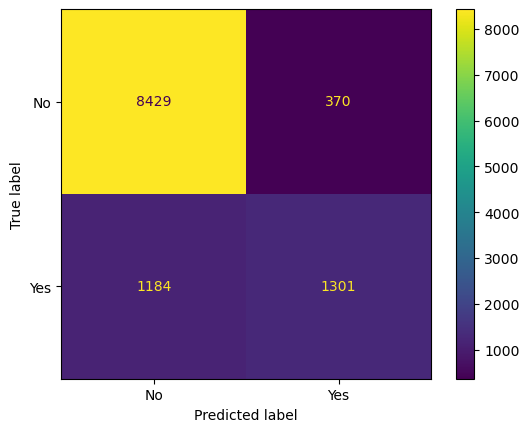

In [27]:
from sklearn.metrics import classification_report, ConfusionMatrixDisplay

# Predict on the test set using the best model found by GridSearchCV
y_pred = grid_search.predict(X_test)

# Print detailed performance metrics: precision, recall, f1-score, accuracy
print("📊 Classification Report:")
print(classification_report(y_test, y_pred))

# Display the confusion matrix
print("🧮 Confusion Matrix:")
ConfusionMatrixDisplay.from_predictions(y_test, y_pred)
plt.show()


<Figure size 1000x600 with 0 Axes>

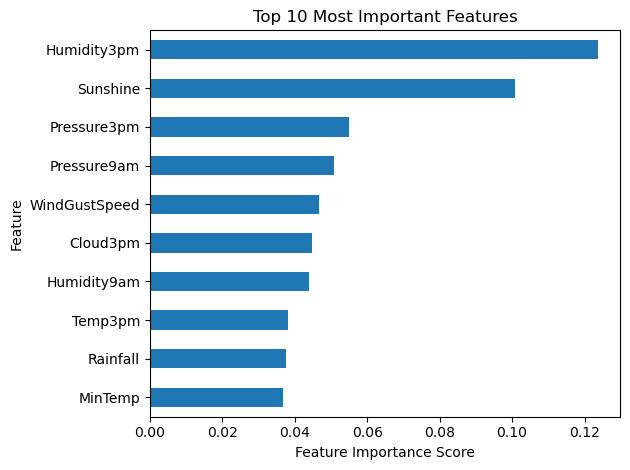

In [29]:
# Recover feature names: numeric features + one-hot encoded categorical features
# First get feature names from the OneHotEncoder step
ohe_feature_names = list(
    grid_search.best_estimator_['preprocessor']
    .named_transformers_['cat']['onehot']
    .get_feature_names_out(categorical_features)
)

# Combine with numeric feature names
feature_names = numeric_features + ohe_feature_names

# Get feature importances from the trained RandomForest model
importances = grid_search.best_estimator_['classifier'].feature_importances_

# Create a DataFrame to organize and sort the importances
importance_df = pd.DataFrame({
    'Feature': feature_names,
    'Importance': importances
}).sort_values(by='Importance', ascending=False)

# Plot the top 10 most important features
plt.figure(figsize=(10, 6))
importance_df.head(10).plot(kind='barh', x='Feature', y='Importance', legend=False)
plt.title('Top 10 Most Important Features')
plt.xlabel('Feature Importance Score')
plt.gca().invert_yaxis()
plt.tight_layout()
plt.show()
